# Beyond the Random Forest: Faster and Furiouser
## Andrew Humphrey
### IA Programmer's Club 21 Sept 2020
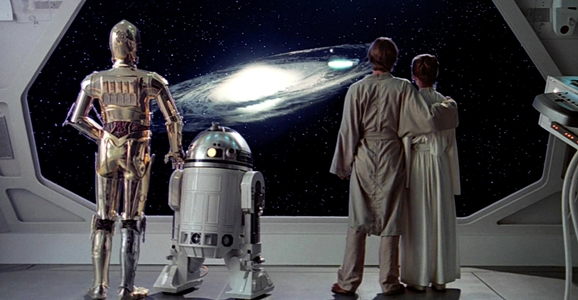

In [ ]:
# python 3 notebook for Programmer's Club 18 Sept 2020
# import the usual data science and general things

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time, random, warnings
warnings.filterwarnings('ignore')

# import what we need from Scikit-Learn
from sklearn import neighbors, neural_network
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis

# import several cutting edge tree-based learners
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [2]:
#from astroquery.sdss import SDSS  # enables direct queries to the SDSS database
#this example was taken from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions
# also presented by Tunde

#STAR_GALquery = """SELECT TOP 20000
#                p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
#                p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
#                s.class
#                FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
#                WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
#                ORDER BY p.objid ASC"""

#stars_gals = SDSS.query_sql(STAR_GALquery)
#stars_gals["class"]=np.array(stars_gals["class"], dtype=np.str)

# thanks to Tom Scott for the file
df = pd.read_csv('stars_gals')

# summary of the data:
print('number of astronomical objects:',len(df))
print('columns:',df.columns.values)
print('unique classes:',df['class'].unique())

number of astronomical objects: 20000
columns: ['psfMag_r' 'fiberMag_r' 'fiber2Mag_r' 'petroMag_r' 'deVMag_r' 'expMag_r'
 'modelMag_r' 'cModelMag_r' 'class']
unique classes: ['GALAXY' 'STAR']


In [3]:
# preprocessing before we apply machine learning

# create binary target column from class name strings
df['Target'] = (df['class'] == 'GALAXY').astype(int)
# check it worked
df[['Target','class']]

# make list of columns to use as training features
cols = df.columns.values.tolist()
cols.remove('class')
cols.remove('Target')

# standardize / scale the features to be used for model training
# note: magnitudes and colours often don't need scaling since they are already logarithmic
scaler = StandardScaler()
scaler.fit(df[cols])
df[cols] = scaler.transform(df[cols])
# let's looks at the results
df.head()

,psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class,Target
0,-0.460980,-0.456968,-0.387287,-0.655817,-0.719171,-0.669434,-0.601619,-0.655157,GALAXY,1
1,-0.169385,-0.068947,-0.116434,0.200199,0.249467,0.147178,0.219833,0.219415,STAR,0
2,0.306565,0.193642,0.259301,0.367189,0.334939,0.329573,0.403310,0.340907,GALAXY,1
3,1.507000,1.512229,1.527126,1.591933,1.376655,1.435021,1.515309,1.514541,GALAXY,1
4,1.246063,1.230142,1.262818,0.992363,0.755588,0.917236,0.994422,0.883807,GALAXY,1


## Let's compare Scikit-Learn's Random Forest to other learning algorithms

In [4]:
# Random Forest from Scikit-Learn: classify objects according to star (0) or galaxy (1)
# start with the usual train / test split
acc = 0
n_iter = 10
#state_list = [random.randrange(1, 9999, 1) for _ in range(10)] 
state_list = [3019, 2454, 4539, 2734, 9868, 2706, 2267, 9736, 4497, 659]

t0 = time.time()
for i in tqdm(range(0,n_iter)):
    X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Target'],test_size=0.25, random_state = state_list[i])

    # define a model
    clf = RandomForestClassifier(n_estimators=50,n_jobs=3)
    
    # fit the model to the training data
    clf.fit(X_train, y_train)

    # predict object classes for the test data 
    preds_bin = clf.predict(X_test)
    # evaluate accuracy:    
    acc += accuracy_score(y_test,preds_bin) / n_iter

t1 = time.time()
acc_rf = acc
t_rf = t1-t0
# average accuracy over n_iter runs
print(type(clf).__name__)
print('average accuracy over '+str(n_iter)+' runs:',np.round(acc,4),' time elaped:',np.round(t1-t0,2),'s')

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

RandomForestClassifier
average accuracy over 10 runs: 0.9689  time elaped: 10.8 s


In [102]:
def eval_results():
    if (acc - acc_rf) >= 0: plus = '+'
    else: plus = ''
    acc_diff_str = '('+plus+str(np.round(acc - acc_rf,4))+').'
    t_diff_str = '('+str(int((t1-t0)/t_rf*100.))+'%)'
    print(type(clf).__name__)
    print('average accuracy over '+str(n_iter)+' runs:',np.round(acc,4),acc_diff_str+' time elaped:',np.round(t1-t0,2),'s',t_diff_str)

### CatBoost is more accurate and significantly faster

In [104]:
# now lets try Catboost
acc = 0
n_iter = 10
t0 = time.time()
for i in tqdm(range(0,n_iter)):
    X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Target'],test_size=0.25,random_state = state_list[i])
    clf = CatBoostClassifier(logging_level='Silent',thread_count=3, n_estimators=50)
    clf.fit(X_train, y_train)
    preds_bin = clf.predict(X_test)
    acc += accuracy_score(y_test,preds_bin) / n_iter

t1 = time.time()
eval_results()

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

CatBoostClassifier
average accuracy over 10 runs: 0.9691 (+0.0002). time elaped: 6.83 s (63%)


### Light GBM is even more accurate and ~6 times faster than RandomForest

In [7]:
# now lets try Light GBM

acc = 0
n_iter = 10
t0 = time.time()
for i in tqdm(range(0,n_iter)):
    X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Target'],test_size=0.25,random_state = state_list[i])
    clf = lgb.LGBMClassifier(n_jobs = 3,n_estimators=50)
    clf.fit(X_train, y_train)
    preds_bin = clf.predict(X_test)
    acc += accuracy_score(y_test,preds_bin) / n_iter

t1 = time.time()
eval_results()

100%|██████████| 10/10 [00:01<00:00,  5.74it/s]

LGBMClassifier
average accuracy over 10 runs: 0.9702 (+0.0014). time elaped: 1.75 s (16%)


### XGBoost is less accurate for this classification problem, but faster

In [105]:
# XGBoost (not ideal for this problem, but included for completeness)

acc = 0
n_iter = 10
t0 = time.time()
for i in tqdm(range(0,n_iter)):
    X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Target'],test_size=0.25,random_state = state_list[i])
    clf = xgb.XGBClassifier(n_estimators=50,n_jobs=3,tree_method='exact')
    clf.fit(X_train, y_train)
    preds_bin = clf.predict(X_test)  
    acc += accuracy_score(y_test,preds_bin) / n_iter

t1 = time.time()
eval_results()

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

XGBClassifier
average accuracy over 10 runs: 0.9636 (-0.0052). time elaped: 9.53 s (88%)


### Let's try some others for completeness. ExtraTreesClassifier is faster but less accurate:

In [106]:
#Scikit-Learn ExtraTreesClassifier

acc = 0
n_iter = 10
t0 = time.time()
for i in tqdm(range(0,n_iter)):
    X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Target'],test_size=0.25,random_state = state_list[i])
    clf = ExtraTreesClassifier(n_estimators=50,n_jobs=3)
    clf.fit(X_train, y_train)
    preds_bin = clf.predict(X_test)  
    acc += accuracy_score(y_test,preds_bin) / n_iter

t1 = time.time()
eval_results()

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

ExtraTreesClassifier
average accuracy over 10 runs: 0.9678 (-0.0011). time elaped: 7.86 s (72%)


### GradientBoostingClassifier is 3 times slower and less accurate for this classification problem. Nevermind.

In [10]:
#GradientBoostingClassifier
# (apparently doesn't have an n_jobs parameter --> slow)

acc = 0
n_iter = 10
t0 = time.time()
for i in tqdm(range(0,n_iter)):
    X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Target'],test_size=0.25,random_state = state_list[i])
    clf = GradientBoostingClassifier(n_estimators=50)
    clf.fit(X_train, y_train)
    preds_bin = clf.predict(X_test)  
    acc += accuracy_score(y_test,preds_bin) / n_iter

t1 = time.time()
eval_results()

100%|██████████| 10/10 [00:35<00:00,  3.55s/it]

GradientBoostingClassifier
average accuracy over 10 runs: 0.9634 (-0.0054). time elaped: 35.53 s (329%)


### I really like the simplicity of implementing a deep learning neural network using Scikit-Learn's MLPClassifier: slow, but often gives decent results.

In [107]:
# a simple deep learning NN from Scikit-Learn
# (slow but quite accurate)

acc = 0
n_iter = 10
t0 = time.time()
for i in tqdm(range(0,n_iter)):
    X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Target'],test_size=0.25,random_state = state_list[i])
    clf = neural_network.MLPClassifier(activation='tanh', solver='adam', tol=1e-05, hidden_layer_sizes=(8,8,8,8),
                                       max_iter=300,learning_rate_init = 0.0001)
    clf.fit(X_train, y_train)
    preds_bin = clf.predict(X_test)
    acc += accuracy_score(y_test,preds_bin) / n_iter

t1 = time.time()
eval_results()

100%|██████████| 10/10 [06:13<00:00, 37.37s/it]

MLPClassifier
average accuracy over 10 runs: 0.9702 (+0.0013). time elaped: 373.76 s (3461%)


## Why stop at individual models when you can combine the best ones into a single, potentially stronger model?

In [153]:
# now let's look at simple model emsembling
# train different learners on the same data and combine the results

# train test split again
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Target'],test_size=0.95,random_state = 42)

# create a dictionary of learning algorithms
models = {'nn':neural_network.MLPClassifier(activation='tanh', solver='adam', tol=1e-05, 
                                            hidden_layer_sizes=(8,8,8,8),max_iter=300,
                                            learning_rate_init = 0.0001),
          'RandomForest':RandomForestClassifier(n_estimators=50,n_jobs=3),
          'lgbm':lgb.LGBMClassifier(n_jobs = 3,n_estimators=50),
          'catboost':CatBoostClassifier(logging_level='Silent',thread_count=3, n_estimators=50),
          'knn':neighbors.KNeighborsClassifier(n_neighbors=25),
          #'ExtraTrees':ExtraTreesClassifier(n_estimators=50,n_jobs=3),
          #'XGBoost':xgb.XGBClassifier(n_estimators=50,n_jobs=3,tree_method='exact')
         }

# set up empty arrays to compute average and hard votes
preds_array = np.zeros((len(models),len(y_test)))
preds_avg = np.zeros(len(y_test))

acc_list=[]
for i,name in enumerate(list(models.keys())):
    if i==0: 
        print('running models ...') 
    #train and predict
    clf = models[name]
    clf.fit(X_train, y_train)
    preds_bin = clf.predict(X_test)
    preds_proba = clf.predict_proba(X_test)[:,1]
    
    # fill arrays
    preds_array[i,:] = preds_bin
    preds_avg += preds_proba / len(models)
    
    # accuracy of individual learners
    acc = accuracy_score(y_test,preds_bin)
    print(type(clf).__name__,np.round(acc,4))
    acc_list.append(np.round(acc,4))

preds_vote = np.where(np.mean(preds_array,axis=0) > 0.5, 1, 0) 

# check accuracy of ensembles
print('\nbest learning algorithm:',max(acc_list),'\n')

print('averaged predictions accuracy:',np.round(accuracy_score(y_test,np.where(preds_avg > 0.5, 1, 0)),4))
print('hard voting accuracy:',np.round(accuracy_score(y_test,preds_vote),4))


running models ...
MLPClassifier 0.9665
RandomForestClassifier 0.9589
LGBMClassifier 0.9615
CatBoostClassifier 0.9579
KNeighborsClassifier 0.9605

best learning algorithm: 0.9665 

averaged predictions accuracy: 0.9657
hard voting accuracy: 0.9656


## Generalised Stacking using K-fold
Below is a simple schematic of K-fold process. In the case of generalised stacking, we save the out of fold (AKA validation fold) predictions and use them to construct a new set of features. Because we use several different learning algorithms, we build one out of fold Series for each learner, and combine them all into new DataFrame, which we use to train the meta-learner (AKA super-learner or level-2-learner). 

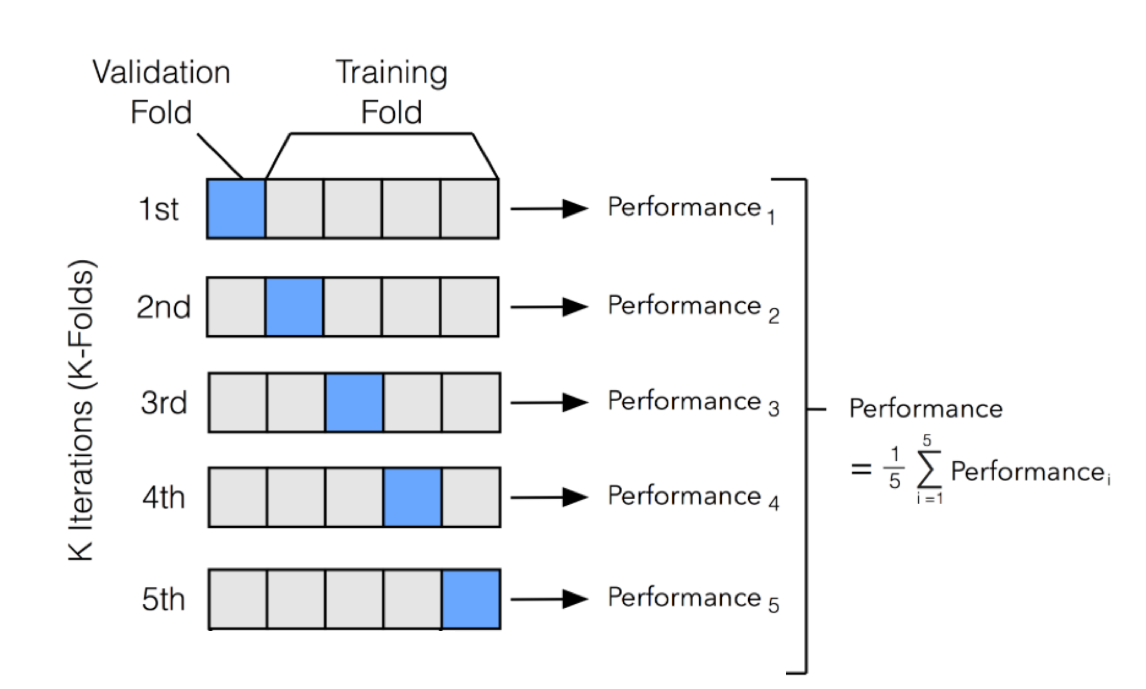

In [112]:
# Generalised Stacking
# in a nutshell, we train models using stratified K-fold, and save the out-of-fold predictions
# we then use the out-of-fold predictions as features to train a meta-learner

X_train = X_train.reset_index().drop('index',axis=1)
X_test = X_test.reset_index().drop('index',axis=1)

#print(X_train.head())

def train_kf_oof(clf,X_train,y_train,X_test,nkf=5):
    oof_train = pd.Series([0]).repeat(len(X_train))
    preds = pd.Series([0]).repeat(len(X_test))

    skf = StratifiedKFold(n_splits=nkf, shuffle=True)
    for train_index, oof_index in skf.split(X_train, y_train):
        X_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        X_te = X_train.iloc[oof_index]

        # detect LGBM and use specific option for it
        if str(type(clf).__name__) == 'LGBMClassifier':
            clf.fit(X_tr, y_tr,verbose=False)
        else:
            clf.fit(X_tr, y_tr)
        
        # save the OOF class probability predictions and test set class probability predictions
        oof_train.iloc[oof_index] = clf.predict_proba(X_te)[:,1]
        preds += clf.predict_proba(X_test)[:,1]/skf.n_splits
    
    oof_train.index = X_train.index
    preds.index = X_test.index
    return oof_train, preds
    
train_meta = pd.DataFrame(index=X_train.index,columns=[*models])
test_meta = pd.DataFrame(index=X_test.index, columns=[*models])

acc_list = []

for i, model_name in enumerate([*models]):
    if i==0: print('running models ...')
    
    train_meta[model_name], test_meta[model_name] = train_kf_oof(models[model_name],X_train,y_train,X_test,nkf=5)
        
    # show accuracy for each learner using strat k-fold (test set)
    acc = np.round(accuracy_score(y_test,np.where(test_meta[model_name]>0.5, 1, 0)),4)
    print(str(type(models[model_name]).__name__)+' acc: '+str(np.round(acc,4)))
    acc_list.append(acc)
    
# let's take a look at the features for training our meta learner:
test_meta['average'] = test_meta[[*models]].mean(axis=1)
train_meta['average'] = train_meta[[*models]].mean(axis=1)
train_meta['Target'] = y_train.values
print(train_meta.round(2))

running models ...
MLPClassifier acc: 0.9524
RandomForestClassifier acc: 0.9626
LGBMClassifier acc: 0.9633
CatBoostClassifier acc: 0.9573
KNeighborsClassifier acc: 0.9573
           nn  RandomForest      lgbm  catboost   knn   average  Target
0    0.193933          0.00  0.008700  0.094763  0.04  0.067479       0
1    0.797193          1.00  0.997162  0.942363  1.00  0.947343       1
2    0.665738          0.88  0.686434  0.779559  0.88  0.778346       0
3    0.596827          0.84  0.985429  0.736926  0.96  0.823836       1
4    0.135808          0.00  0.003347  0.063734  0.00  0.040578       0
..        ...           ...       ...       ...   ...       ...     ...
995  0.869427          1.00  0.994758  0.951008  1.00  0.963038       1
996  0.160718          0.00  0.003410  0.087710  0.00  0.050368       0
997  0.176691          0.06  0.004286  0.061331  0.00  0.060462       0
998  0.122354          0.02  0.003132  0.074423  0.00  0.043982       0
999  0.837132          1.00  0.997046

### Out of curiosity, let's look at cases where the classifiers got it wrong
For this classification problem, it is almost always the case that when one of the 5 base learners gets it wrong, the other 4 are also wrong. However, in cases where the base learners disagree, the meta-learner will try to figure out things like when to trust a particular learner over the other 4.

In [151]:
# look at cases where the predictions are incorrect
print('cases where classification is incorrect:')
test_meta_wrong = test_meta[test_meta['Target'] != np.where(test_meta[[*models]].mean(axis=1) > 0.5, 1, 0)]
print(test_meta_wrong.round(2).head(),'\n')
print('cases where classification is incorrect AND individual learners strongly disagree:')
test_meta_wrong2 = test_meta_wrong[test_meta_wrong[[*models]].max(1) - test_meta_wrong[[*models]].min(1) >= 0.5]
print(test_meta_wrong2.round(2).head())

cases where classification is incorrect:
       nn  RandomForest  lgbm  catboost   knn  average  meta_lda  Target
51   0.54          0.31  0.17      0.41  0.35     0.36         0       1
89   0.79          0.99  0.99      0.92  1.00     0.94         1       0
123  0.27          0.24  0.32      0.32  0.29     0.29         0       1
140  0.63          0.85  0.92      0.65  0.52     0.72         1       0
142  0.25          0.02  0.01      0.20  0.13     0.12         0       1 

cases where classification is incorrect AND individual learners strongly disagree:
        nn  RandomForest  lgbm  catboost   knn  average  meta_lda  Target
219   0.43          0.35  0.87      0.55  0.28     0.50         1       1
487   0.68          0.40  0.62      0.15  0.35     0.44         1       1
1019  0.85          0.33  0.40      0.14  0.22     0.39         1       1
1142  0.45          0.58  0.91      0.48  0.34     0.55         1       0
1325  0.35          0.67  0.98      0.47  0.22     0.54         1 

### Finally, we train meta-learners on the OOF predictions of the training data
The meta-learning will try to make a new classifier that considers the reliability of the individual learners, and looks for patterns in the OOF predictions. The improvement over individual learners is small but significant in this case, with LinearDiscriminantAnalysis producing the most accurate meta-learner. 


Looking at the table below, one can see that, for instance, the meta learner identified a trend where the neural network and Light GBM both correctly predicted class 1, but the other learners incorrectly predicted class 0. 

In [130]:
#apply meta-learner and make new predictions
# make new dictionary of learning algorithms / models
models2 = {}

#models2['nn'] = neural_network.MLPClassifier(activation='relu', solver='adam', tol=1e-05, 
#                                            hidden_layer_sizes=(5,5),max_iter=300,
#                                            learning_rate_init = 0.0001)

models2['lda'] = LinearDiscriminantAnalysis()
models2['qda'] = QuadraticDiscriminantAnalysis()
models2['catboost'] = CatBoostClassifier(logging_level='Silent',thread_count=3)
models2['RandomForest'] = RandomForestClassifier(n_estimators=50,n_jobs=3)
models2['lgbm'] = lgb.LGBMClassifier(n_jobs = 3,n_estimators=50)


cols2 = [*models]
cols2.append('average')

acc_previous_best = max(acc_list)
print(np.round(acc_previous_best,4),'Previous best individual model')
print('META-LEARNERS:')

for i, model_name in enumerate([*models2]):
    clf = models2[model_name]
    clf.fit(train_meta[cols2], y_train)
    preds_meta = clf.predict(test_meta[cols2])
    preds_proba_meta = clf.predict_proba(test_meta[cols2])[:,1]
    if i==0: 
        preds_lda = preds_meta
    
    acc = accuracy_score(y_test,preds_meta)
    print(str(np.round(acc,4))+' ('+str(np.round(acc-acc_previous_best,4))+' change) '+str(type(clf).__name__))

0.9633 Previous best individual model
META-LEARNERS:
0.9659 (0.0026 change) LinearDiscriminantAnalysis
0.9656 (0.0023 change) QuadraticDiscriminantAnalysis
0.966 (0.0027 change) CatBoostClassifier
0.966 (0.0027 change) RandomForestClassifier
0.9651 (0.0018 change) LGBMClassifier


In [150]:
# Let's see if we can find some cases where the meta-learner corrected wrong classificatons

test_meta['meta_lda'] = preds_lda
y_test.index = test_meta.index
test_meta['Target'] = y_test

test_meta_corrected = test_meta[(test_meta['Target'] != np.where(test_meta['average']>0.5,1,0)) & 
                               (test_meta['meta_lda'] != np.where(test_meta['average']>0.5,1,0))]

print(len(test_meta_corrected),'out of',len(test_meta_wrong),'misclassifications got corrected\n')
print('Some examples:')
print(test_meta_corrected[test_meta_corrected['Target']==1].round(2).sample(10))
print(test_meta_corrected[test_meta_corrected['Target']==0].round(2).sample(10))

59 out of 667 misclassifications got corrected

Some examples:
         nn  RandomForest  lgbm  catboost   knn  average  meta_lda  Target
11017  0.70          0.26  0.57      0.44  0.50     0.49         1       1
13158  0.89          0.46  0.40      0.17  0.27     0.44         1       1
3339   0.29          0.58  0.97      0.38  0.13     0.47         1       1
6748   0.74          0.33  0.63      0.15  0.24     0.42         1       1
7039   0.66          0.40  0.88      0.17  0.29     0.48         1       1
3321   0.33          0.56  0.69      0.54  0.33     0.49         1       1
5259   0.81          0.46  0.40      0.15  0.19     0.40         1       1
10367  0.78          0.55  0.40      0.16  0.19     0.42         1       1
2029   0.79          0.44  0.73      0.17  0.32     0.49         1       1
14764  0.92          0.53  0.40      0.17  0.31     0.47         1       1
         nn  RandomForest  lgbm  catboost   knn  average  meta_lda  Target
18738  0.56          0.46  0.45      

## Discussion and Concluding Remarks

1. The RandomForest method from Scikit-Learn is good, but there are several newer tree-based methods that are considerably faster, and usually more accurate. CatBoost and Light GBM are both very interesting in this regard. However, there is probably no substitute for simply trying out various methods on your data to discover which ones work best for your classification (or regression) problem. Occasionally, RandomForest gives slightly better results than the others.  


2. CatBoost may be slightly slower than Light GBM, but it has some novel features that can make it more useful under some circumstances, including its treatment of categorical features (e.g., galaxy morphology etc.). 


3. Deep-learning can be easily applied to tabular data (not just images), and in some circumstances can give better results than tree-based methods. However, deep learning methods tend to be more CPU-intensive.


4. When you want to reach the best possible model accuracy, ensemble methods are essential. Averaging, hard-voting, or non-linear model stacking usually all achieve higher accuracy than any of the single base-learners. The usefulness of these methods generally increases when your classification problem is more difficult (e.g., using complex and/or less than perfect data). The importance of ensembling different methods is often not clear when one only uses the clean / perfect data that are usually given in popular machine learning manuals/tutorials.


Below I illustrate a real world case where generalised stacking does its job well. The training data is a set of 4 broad-band photometry measurements for several hundred thousand galaxies in the COSMOS field, and the objective is to separate them into passive galaxies in a chosen redshift range, and all other galaxies. My machine learning pipeline needs to determine the galaxy redshift AND the specific star formation rate, from the 4 broad band magnitudes (and the respective colours). This is a tough problem, because there are significant degeneracies, such as that between dusty (red) star-forming galaxies and passive galaxies (also red). The fact that more distant galaxies tend to have more missing photometry and lower signal to noise measurements also make it challenging. 


Column 4 shows the challenging case of trying to select passive galaxies at z=2-3, where such galaxies are very rare (at least in the catalogues). In this case, the different learners give low F1-scores (the metric used in the table), but they appear to be able to fit differing subsets of the data, so that when their results are combined, we obtain a single classifier that is significantly stronger than any of the indivivual classifiers. (Because the data used in the table below contains information that cannot be shared outside of the Euclid Consortium, I was not able to show this pipeline in action).


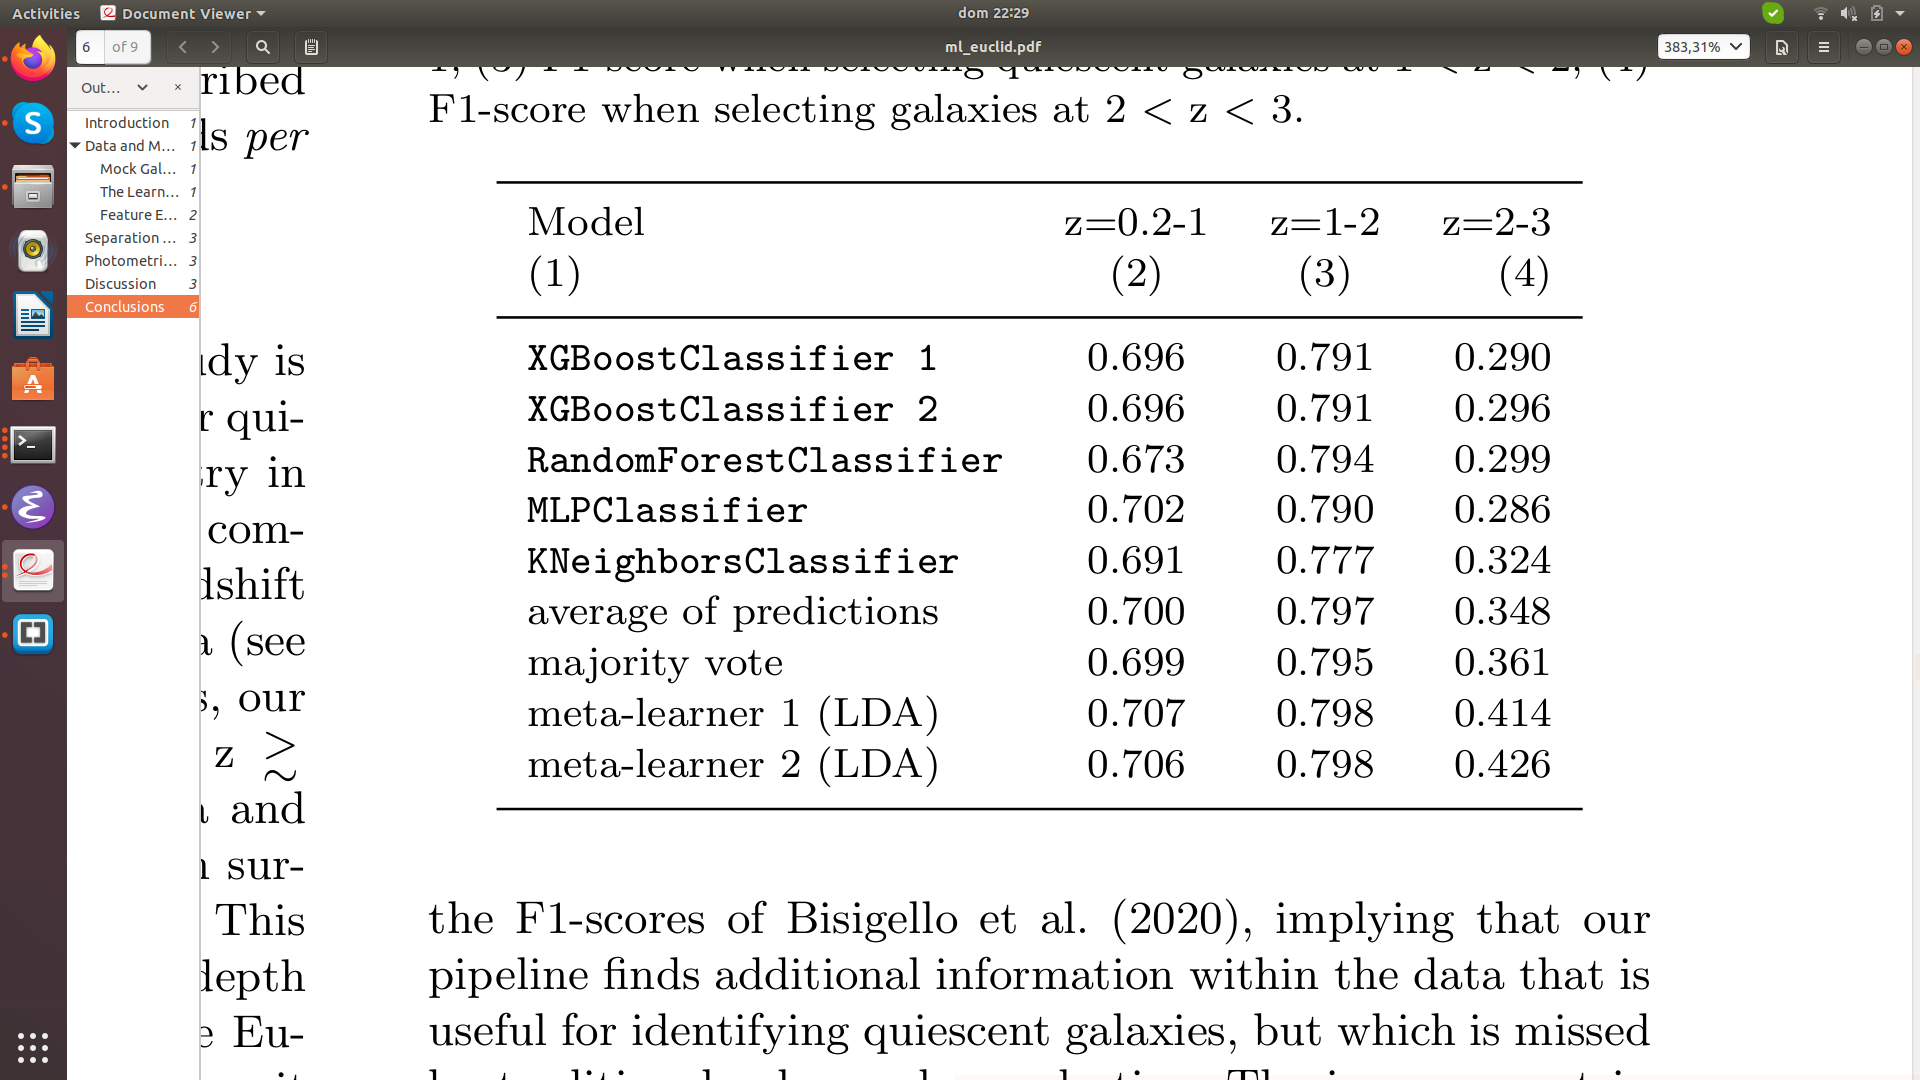


### Further reading

https://catboost.ai/docs/

https://lightgbm.readthedocs.io/en/latest/

https://xgboost.readthedocs.io/en/latest/

https://scikit-learn.org/stable/